# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.

# Решение 

Импорт всех необходимых библиотек.

In [1]:
!pip install arch

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

Импортируем датасет. 

In [3]:
data = pd.read_csv('/Users/valeriaastahova/Desktop/Машинное обучение Нетология/Датасеты/Временные ряды/Series/weekly-closings-of-the-dowjones-.csv')

In [4]:
series = data['Close']
series

0      890.19
1      901.80
2      888.51
3      887.78
4      858.43
        ...  
157    791.77
158    787.23
159    787.94
160    784.57
161    752.58
Name: Close, Length: 162, dtype: float64

Пропишем основные функции. 

In [5]:
def test_stationarity(timeseries): #тест на стационарность
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'): #график
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [7]:
def _get_best_model(TS): #ARIMA
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

Посмотрим на наш ряд. 

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


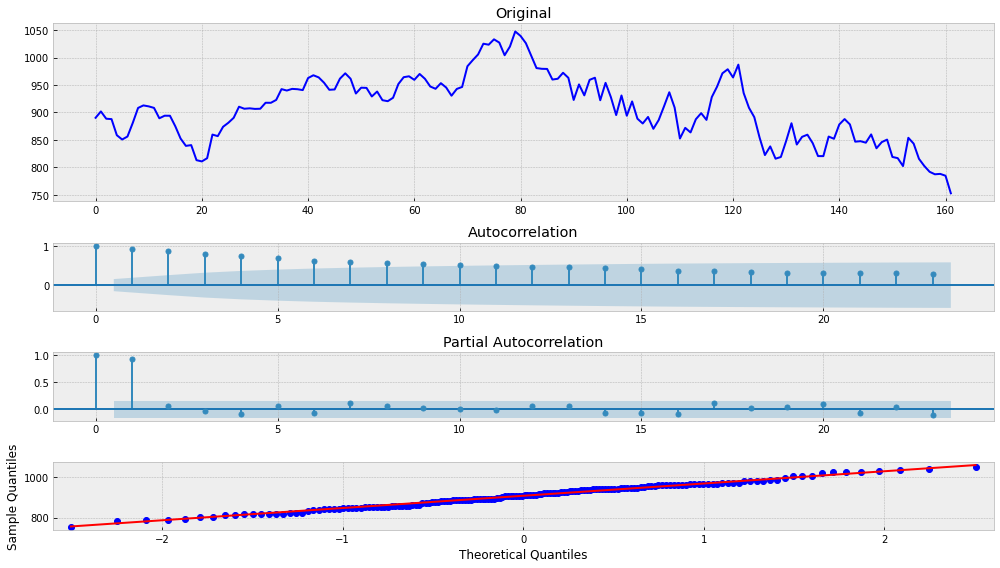

In [8]:
tsplot(series)

Применим ARIMA к нашему ряду. 

In [9]:
aic, order, mdl = _get_best_model(series)

aic: 1416.27670 | order: (2, 2, 3)


Лучшие показатели - 2,2,3. Их мы и будем использовать в модели GARCH. Построим график остатков по модели ARIMA.

Results of Dickey-Fuller Test:
Test Statistic                -1.184570e+01
p-value                        7.408629e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


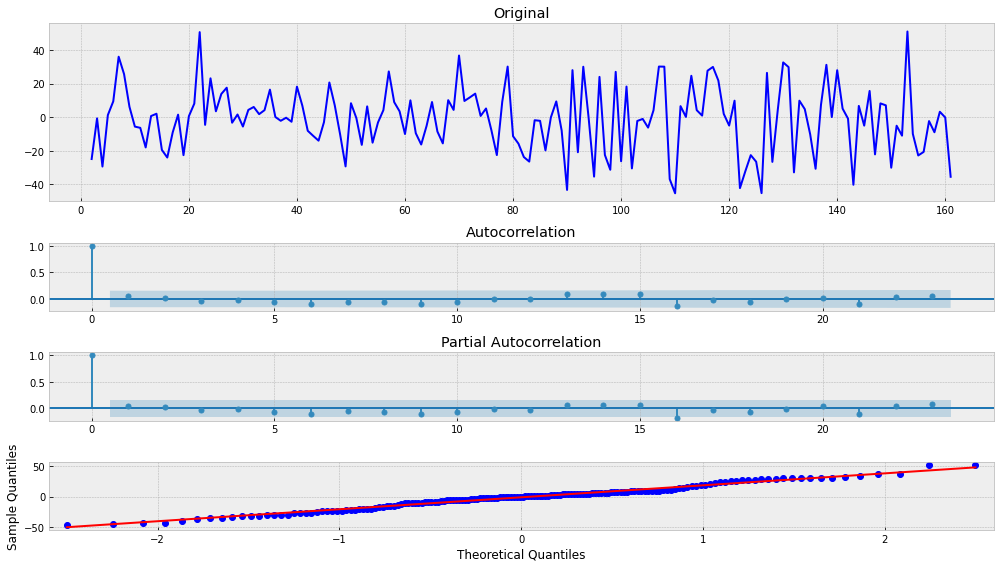

In [10]:
tsplot(mdl.resid)

Применим GARCH c параметрами из ARIMA

In [11]:
p_ = 2
o_ = 2
q_ = 3

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -853.442
Distribution:      Standardized Student's t   AIC:                           1726.88
Method:                  Maximum Likelihood   BIC:                           1757.76
                                              No. Observations:                  162
Date:                      Tue, Dec 29 2020   Df Residuals:                      152
Time:                              12:18:38   Df Model:                           10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


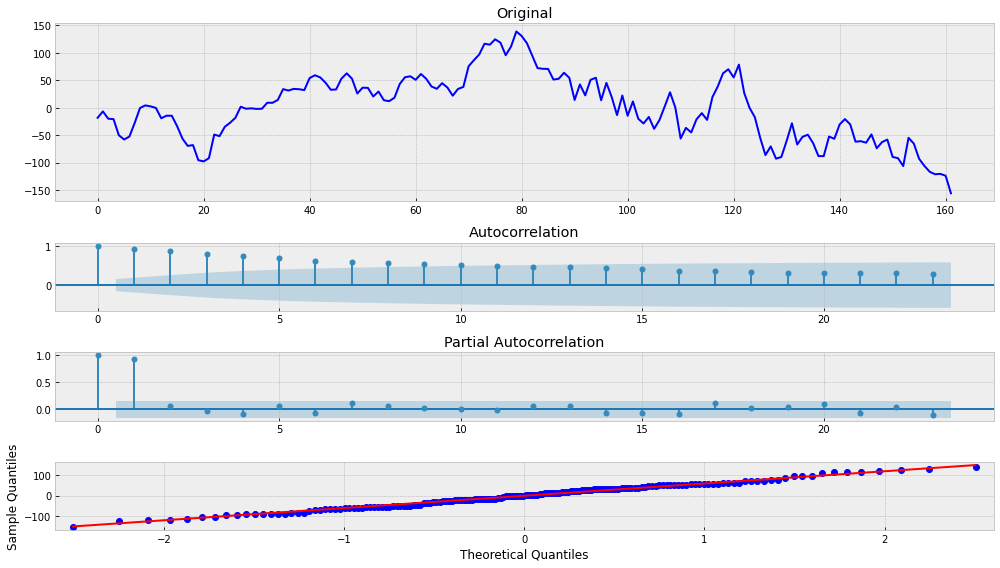

In [12]:
tsplot(res.resid)

### Те же манипуляции, только с дифференцированным рядом

In [13]:
new_series = np.diff(series, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


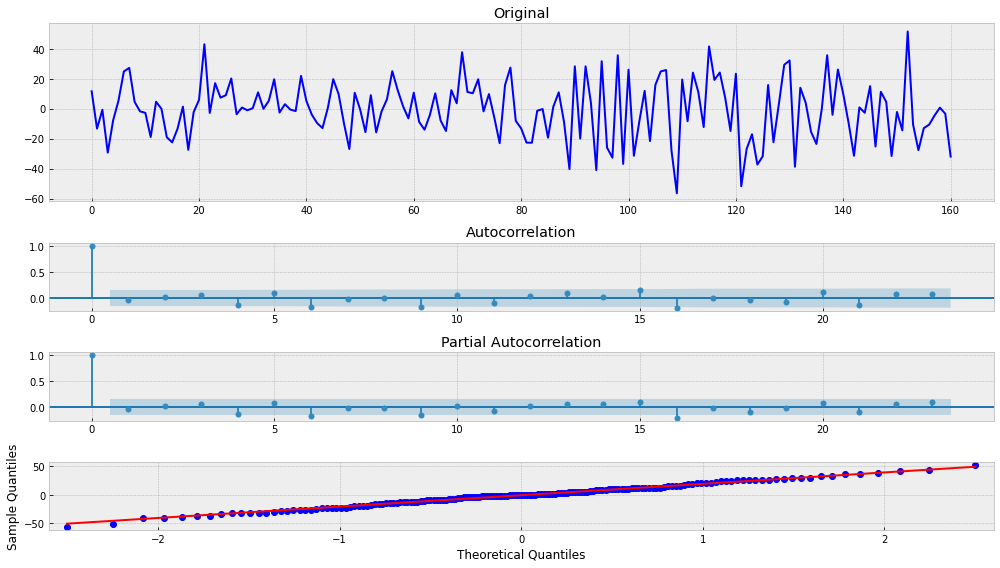

In [14]:
tsplot(new_series)

In [15]:
aic, order, mdl = _get_best_model(new_series)

aic: 1416.27670 | order: (2, 1, 3)


Results of Dickey-Fuller Test:
Test Statistic                -1.184570e+01
p-value                        7.408629e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


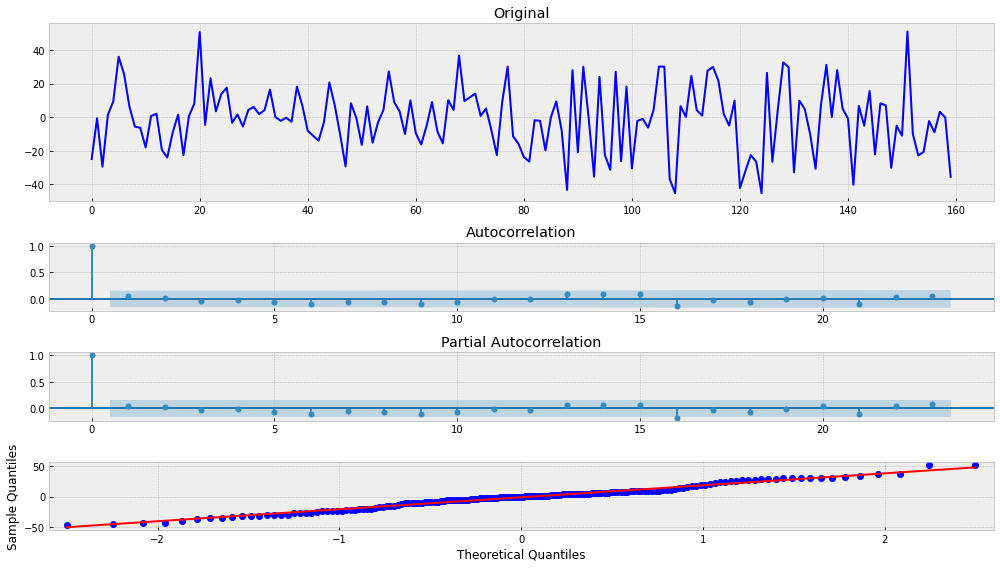

In [16]:
tsplot(mdl.resid)

In [17]:
p_ = 2
o_ = 1
q_ = 3

am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -698.893
Distribution:      Standardized Student's t   AIC:                           1415.79
Method:                  Maximum Likelihood   BIC:                           1443.52
                                              No. Observations:                  161
Date:                      Tue, Dec 29 2020   Df Residuals:                      152
Time:                              12:19:00   Df Model:                            9
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


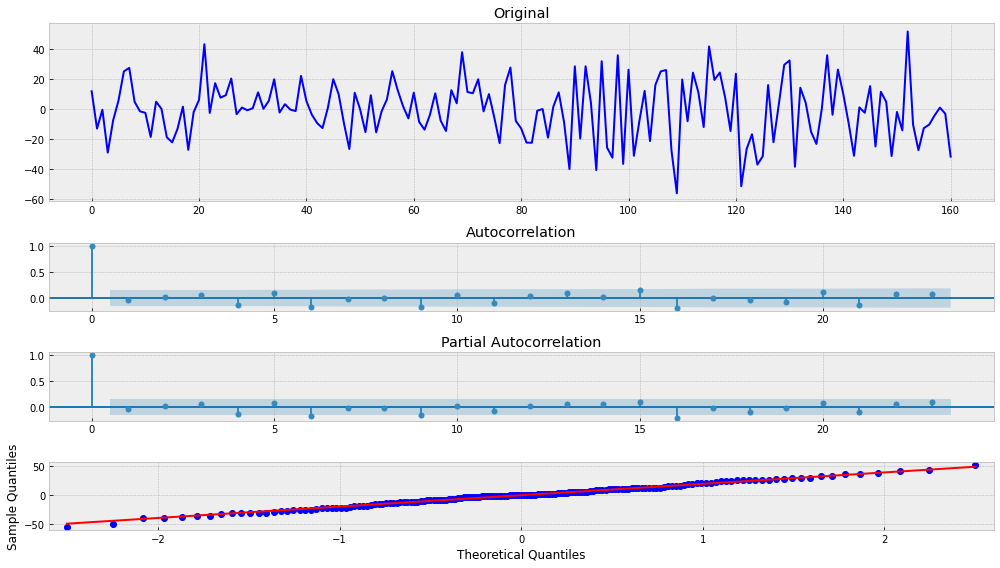

In [18]:
tsplot(res.resid)